In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv('/content/drive/MyDrive/nga-east_rotd50_5pct_flatfile_public_20141118.csv')

<ipython-input-4-7c6d58b58cf2>:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/drive/MyDrive/nga-east_rotd50_5pct_flatfile_public_20141118.csv')


In [5]:
df = df.drop_duplicates()
df = df.drop(df[df['Joyner-Boore Dist. (km)'] == -999 ].index)
df = df.drop(df[df['Joyner-Boore Dist. (km)'] > 1500 ].index)
df = df.drop(df[df['PGA-H RotDnn (g)'] == -999 ].index)
df = df.drop(df[df['HypD (km)'] <= 0 ].index)

In [6]:

rows, cols = df.shape

print("Number of rows:", rows)
print("Number of columns:", cols)

Number of rows: 8083
Number of columns: 517


In [7]:
df.reset_index()

,index,Record Sequence Number,EQID,Earthquake Name,Earthquake Location,Year,Month,Day,Hour,Minute,...,T8.511363s,T8.709663s,T8.912497s,T9s,T9.120093s,T9.332537s,T9.5s,T9.549913s,T9.772401s,T10s
0,0,42,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,...,3.371480e-04,3.214520e-04,3.055400e-04,2.988270e-04,2.896760e-04,2.737270e-04,2.631590e-04,2.601610e-04,2.482690e-04,2.365760e-04
1,1,43,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,...,7.981870e-05,7.618600e-05,7.271660e-05,7.126930e-05,6.938110e-05,6.621790e-05,6.387290e-05,6.319790e-05,6.031420e-05,5.756260e-05
2,2,49,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,...,1.613400e-04,1.537930e-04,1.466720e-04,1.437700e-04,1.399400e-04,1.335270e-04,1.288400e-04,1.274950e-04,1.217690e-04,1.163280e-04
3,3,51,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,...,1.462360e-04,1.395990e-04,1.332670e-04,1.306680e-04,1.272240e-04,1.214550e-04,1.171800e-04,1.159490e-04,1.106930e-04,1.056780e-04
4,4,52,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,...,1.113560e-04,1.049390e-04,9.863450e-05,9.589730e-05,9.246470e-05,8.669810e-05,8.277760e-05,8.168850e-05,7.717850e-05,7.334710e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8078,9377,12062,117,Saguenay_1988-11-26,Saguenay,1988,11,26,3,38,...,8.933050e-08,8.531680e-08,8.146960e-08,7.988330e-08,7.777390e-08,7.422510e-08,7.158480e-08,7.082370e-08,6.757090e-08,6.447040e-08
8079,9378,12063,117,Saguenay_1988-11-26,Saguenay,1988,11,26,3,38,...,1.458760e-07,1.392980e-07,1.330240e-07,1.304630e-07,1.270800e-07,1.214380e-07,1.172640e-07,1.160620e-07,1.109160e-07,1.059250e-07
8080,9379,12064,117,Saguenay_1988-11-26,Saguenay,1988,11,26,3,38,...,9.040710e-08,8.641220e-08,8.256080e-08,8.097280e-08,7.885820e-08,7.529330e-08,7.263440e-08,7.186690e-08,6.858680e-08,6.544350e-08
8081,9380,12065,117,Saguenay_1988-11-26,Saguenay,1988,11,26,3,38,...,1.289430e-07,1.231820e-07,1.176900e-07,1.154530e-07,1.125070e-07,1.075390e-07,1.038150e-07,1.027360e-07,9.808450e-08,9.359120e-08


In [8]:
from sklearn.model_selection import train_test_split
import sklearn as sk

In [9]:
df['Mw/Rjb'] = np.array(df['Earthquake Magnitude']) / np.array(df['Joyner-Boore Dist. (km)'])
df['log Rjb'] = np.log10(df['Joyner-Boore Dist. (km)'])

y = pd.DataFrame()
y['log PGA'] = np.log10(df['PGA-H RotDnn (g)'])
y['log PGV'] = np.log10(df['PGV-H RotDnn (cm/s)'])
t = [0.01 , 0.02 , 0.03 , 0.04 , 0.05,0.06 ,0.07 , 0.08 ,0.09,0.1,0.2 , 0.3 , 0.4, 0.5 ,0.6, 0.7,0.8,0.9,1,2,3,4,5]
for i in t:
    y[f"log PSA {i}s"] = np.log10(df[f"T{i}s"])

X = df[['Earthquake Magnitude', 'Joyner-Boore Dist. (km)', 'log Rjb', 'Mechanism Based on Rake Angle', 'Preferred VS30 (m/sec)']]
# X = df[['Earthquake Magnitude', 'log Rjb', 'Preferred VS30 (m/sec)']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)


In [10]:
import seaborn as sns

<Axes: >

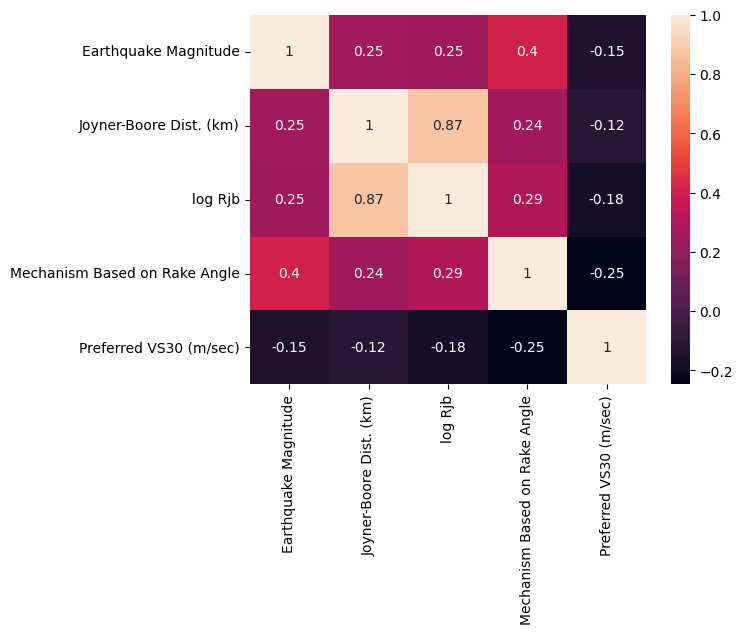

In [11]:
sns.heatmap(df[['Earthquake Magnitude', 'Joyner-Boore Dist. (km)', 'log Rjb', 'Mechanism Based on Rake Angle', 'Preferred VS30 (m/sec)']].corr(), annot = True)

**Artificial Neural Network for getting the RS from the inputs.**

In [14]:
class ANN(nn.Module):
  def __init__(self,n_input_featurs, hidden_layer, n_output_labels):
    super(ANN, self).__init__()
    self.linear1 = nn.Linear(n_input_featurs, hidden_layer)
    self.linear2 = nn.Linear(hidden_layer, n_output_labels)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = self.linear2(x)

    return x

----------------------------------------------------------------------------------------------------------------------------------------------------------------

**The whole Variational Auto Encoder Network for encoding and decoding the RS achieved from the ANN model.**

In [15]:
class Encoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super(Encoder, self).__init__()
    self.l1 = nn.Linear(input_dim, 64)
    # dividing the data into probabilistic distribution
    self.l2_mean = nn.Linear(64, latent_dim)
    self.l2_logvar = nn.Linear(64, latent_dim)

  def forward(self, x):
    x = torch.relu(self.l1(x))
    mean = self.l2_mean(x)
    logvar = self.l2_logvar(x)

    return mean, logvar


In [16]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim):
    super(Decoder, self).__init__()
    self.l1 = nn.Linear(latent_dim, 64)
    self.l2 = nn.Linear(64, output_dim)

  def forward(self, x):
    x = torch.relu(self.l1(x))
    x_recon = self.l2(x)

    return x_recon


In [17]:
class VAE(nn.Module):
  def __init__(self, input_dim, latent_dim, output_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(input_dim, latent_dim)
    self.decoder = Decoder(latent_dim, output_dim)

  def forward(self, x):
    mean, logvar = self.encoder(x)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)   # this takes out a random numbers to create a tensor with mean = 0 and std dev = 1
    z = mean + eps * std
    x_recon = self.decoder(z)    # this is the reconstrucrted Response Spectra (RS)

    return x_recon, mean, logvar

In [18]:
def VAE_loss(x_recon, x, mean, logvar):
  recon_loss = F.mse_loss(x_recon, x, reduction='sum')   # MSE loss between reconstructed RS and actual RS
  kl_d = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())   # this is the KL Divergence Loss function
  return recon_loss + kl_d   # total Loss

----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
n_samples, n_feature = X.shape
n_s, n_labels = y.shape

print(n_samples, n_feature)
print(n_s, n_labels)

batch_size = 32


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state=51)

X_train = torch.tensor(X_train.astype(np.float32).values)
X_test = torch.tensor(X_test.astype(np.float32).values)
y_train = torch.tensor(y_train.astype(np.float32).values)
y_test = torch.tensor(y_test.astype(np.float32).values)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

8083 5
8083 25


***ANN Model***

In [21]:
input_dim_ANN = 5   # 5 parameters on which the RS is to be predicted
output_dim = 25    # output contains log PGA, PGV and PSA for 23 time stamps

In [22]:
model_ANN = ANN(input_dim_ANN, input_dim_ANN + 5, output_dim)

In [23]:
learning_rate1 = 0.001
criterion = nn.MSELoss()
optimizer1 = optim.Adam(model_ANN.parameters(), lr = learning_rate1)

In [24]:
n_epochs = 300

for epoch in range(n_epochs):
  for i, data in enumerate(train_loader):
    input, output = data
    y_pred = model_ANN(input)
    loss = criterion(y_pred, output)

    loss.backward()

    optimizer1.step()
    optimizer1.zero_grad()

    if (i+1)%150 == 0:
      print(f'epoch: {epoch+1}/{n_epochs}, step:{i+1}/{len(train_loader)} loss: {loss.item():.4f}')

epoch: 1/300, step:150/215 loss: 167.7187
epoch: 2/300, step:150/215 loss: 27.2538
epoch: 3/300, step:150/215 loss: 15.3337
epoch: 4/300, step:150/215 loss: 15.6910
epoch: 5/300, step:150/215 loss: 7.0752
epoch: 6/300, step:150/215 loss: 4.4232
epoch: 7/300, step:150/215 loss: 2.6520
epoch: 8/300, step:150/215 loss: 2.7783
epoch: 9/300, step:150/215 loss: 1.4013
epoch: 10/300, step:150/215 loss: 1.8827
epoch: 11/300, step:150/215 loss: 1.3431
epoch: 12/300, step:150/215 loss: 1.3861
epoch: 13/300, step:150/215 loss: 1.6266
epoch: 14/300, step:150/215 loss: 1.2409
epoch: 15/300, step:150/215 loss: 1.2426
epoch: 16/300, step:150/215 loss: 1.0962
epoch: 17/300, step:150/215 loss: 1.0865
epoch: 18/300, step:150/215 loss: 1.1299
epoch: 19/300, step:150/215 loss: 0.8022
epoch: 20/300, step:150/215 loss: 0.8189
epoch: 21/300, step:150/215 loss: 0.8501
epoch: 22/300, step:150/215 loss: 0.9475
epoch: 23/300, step:150/215 loss: 0.8916
epoch: 24/300, step:150/215 loss: 0.8483
epoch: 25/300, step:

In [25]:
model_ANN.eval()
with torch.no_grad():
  y_pred = model_ANN(X_test)

In [56]:
path_ANN = '/content/drive/MyDrive/SEISMIC MODELS/VAE/ANN_model.pth'
torch.save(model_ANN,path_ANN)

In [26]:
y_p = y_pred.detach().numpy()
y_t = y_test.detach().numpy()

In [50]:
from sklearn.metrics import r2_score

# Calculate R^2 score for the first dataframe

for i in range(25):
  r2_score_1 = r2_score(y_p[:,i], y_t[:,i])
  print(f"r2 score for col {i+1}:", r2_score_1)


r2 score for col 1: 0.7865386547944809
r2 score for col 2: 0.8049997623558978
r2 score for col 3: 0.7786304347429915
r2 score for col 4: 0.7870516286661546
r2 score for col 5: 0.7768503535591649
r2 score for col 6: 0.7698783920001984
r2 score for col 7: 0.7687942995454262
r2 score for col 8: 0.7689472382786567
r2 score for col 9: 0.7656835470619927
r2 score for col 10: 0.7591477441767306
r2 score for col 11: 0.7575170691033667
r2 score for col 12: 0.767474633940783
r2 score for col 13: 0.7732758947831753
r2 score for col 14: 0.7390048067817175
r2 score for col 15: 0.7525223286650581
r2 score for col 16: 0.7215217175618178
r2 score for col 17: 0.7413636809885491
r2 score for col 18: 0.7378345090380414
r2 score for col 19: 0.725750367691665
r2 score for col 20: 0.7601242731544517
r2 score for col 21: 0.7181795999540829
r2 score for col 22: 0.811770213758854
r2 score for col 23: 0.8395774980477078
r2 score for col 24: 0.7552424559911841
r2 score for col 25: 0.7512058942639313


***VAE Model***

In [28]:
n_samples, n_feature = X.shape
n_s, n_labels = y.shape

print(n_samples, n_feature)
print(n_s, n_labels)

batch_size = 32


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state=51)

X_train = torch.tensor(X_train.astype(np.float32).values)
X_test = torch.tensor(X_test.astype(np.float32).values)
y_train = torch.tensor(y_train.astype(np.float32).values)
y_test = torch.tensor(y_test.astype(np.float32).values)




8083 5
8083 25


In [29]:
model_ANN.eval()

y_output = model_ANN(X_train)
y_output1 = model_ANN(X_test)

train_dataset_VAE = TensorDataset(y_output, y_output)
test_dataset_VAE = TensorDataset(y_output1, y_output1)
train_loader_VAE = DataLoader(train_dataset_VAE, batch_size = batch_size, shuffle = True)
test_loader_VAE = DataLoader(test_dataset_VAE, batch_size = batch_size, shuffle = True)

In [42]:
input_dim = 25
latent_dim = 4
output_dim = 25
learning_rate = 0.001
epochs = 150
weight_decay = 1e-5

In [43]:
model = VAE(input_dim, latent_dim, output_dim)
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)

In [44]:
for epoch in range(epochs):
  model.train()
  epoch_loss = 0

  for i, data in enumerate(train_loader_VAE):
    _, output = data

    optimizer.zero_grad()

    x_recon, mean, logvar = model(output)

    loss = VAE_loss(x_recon, output, mean, logvar)

    loss.backward(retain_graph=True)
    optimizer.step()

    epoch_loss += loss.item()

    if (i+1)%150 == 0:
      print(f'epoch: {epoch+1}/{epochs}, step:{i+1}/{len(train_loader_VAE)} loss: {loss.item():.4f}')

  print(f'Epoch {epoch+1} completed. Average Loss: {epoch_loss / len(train_loader_VAE):.4f}')

epoch: 1/150, step:150/215 loss: 612.0496
Epoch 1 completed. Average Loss: 2095.4772
epoch: 2/150, step:150/215 loss: 361.4597
Epoch 2 completed. Average Loss: 374.0735
epoch: 3/150, step:150/215 loss: 219.3197
Epoch 3 completed. Average Loss: 251.1869
epoch: 4/150, step:150/215 loss: 196.9895
Epoch 4 completed. Average Loss: 216.5959
epoch: 5/150, step:150/215 loss: 196.9491
Epoch 5 completed. Average Loss: 203.5026
epoch: 6/150, step:150/215 loss: 187.8261
Epoch 6 completed. Average Loss: 195.6841
epoch: 7/150, step:150/215 loss: 198.8930
Epoch 7 completed. Average Loss: 189.6012
epoch: 8/150, step:150/215 loss: 201.8416
Epoch 8 completed. Average Loss: 181.1088
epoch: 9/150, step:150/215 loss: 164.8589
Epoch 9 completed. Average Loss: 174.6377
epoch: 10/150, step:150/215 loss: 164.7762
Epoch 10 completed. Average Loss: 165.9000
epoch: 11/150, step:150/215 loss: 145.4492
Epoch 11 completed. Average Loss: 153.2732
epoch: 12/150, step:150/215 loss: 139.0061
Epoch 12 completed. Average 

In [45]:
model.eval()

with torch.no_grad():
  y_pv,_,_ = model(y_pred)

y_p_vae = y_pv.detach().numpy()
y_t_vae = y_test.detach().numpy()

In [55]:
path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/VAE_model.pth'
torch.save(model,path)

In [49]:
from sklearn.metrics import r2_score

# Calculate R^2 score for the first dataframe

for i in range(25):
  r2_score_1 = r2_score(y_p_vae[:,i], y_t_vae[:,i])
  print(f"r2 score for col {i+1}:", r2_score_1)

r2 score for col 1: 0.7082757651813956
r2 score for col 2: 0.7397405192311601
r2 score for col 3: 0.7080829595828406
r2 score for col 4: 0.7109091575457887
r2 score for col 5: 0.6948847414824554
r2 score for col 6: 0.6853853701078769
r2 score for col 7: 0.6841075095637614
r2 score for col 8: 0.6803274565980726
r2 score for col 9: 0.6778224837282905
r2 score for col 10: 0.6705962893422124
r2 score for col 11: 0.6701823639030184
r2 score for col 12: 0.6733637672866588
r2 score for col 13: 0.6797830278751613
r2 score for col 14: 0.6658833814831209
r2 score for col 15: 0.6840079220722266
r2 score for col 16: 0.6583921272935088
r2 score for col 17: 0.6628417351768363
r2 score for col 18: 0.6590473139001538
r2 score for col 19: 0.6469823861624526
r2 score for col 20: 0.6650455176091559
r2 score for col 21: 0.6272350923685455
r2 score for col 22: 0.6877366443518735
r2 score for col 23: 0.7117280201156018
r2 score for col 24: 0.6137932744287901
r2 score for col 25: 0.5916597256942469


In [47]:
y_pv.shape

torch.Size([1213, 25])

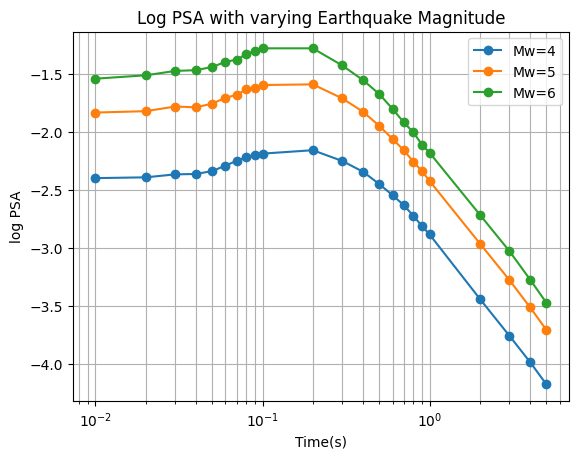

In [ ]:
l=[]

model_ANN.eval()
model.eval()

rjb = 50
focal = 1

r = [4,rjb,np.log10(rjb),focal,760]
r1 = [5,rjb,np.log10(rjb),focal, 760]
r2 = [6,rjb,np.log10(rjb),focal, 760]
r3 = [7,rjb,np.log10(rjb),focal, 760]


l.append(r)
l.append(r1)
l.append(r2)
# l.append(r3)


l = torch.tensor(l, dtype=torch.float32)


with torch.no_grad():
  rp = model_ANN(l)
with torch.no_grad():
  prs,_,_ = model(rp)

plt.plot(t, prs[0][2:], "-o", label='Mw=4')
plt.plot(t, prs[1][2:], "-o", label='Mw=5')
plt.plot(t, prs[2][2:], "-o", label='Mw=6')
# plt.plot(t, prs[3][2:], "-o", label='Mw=7')

plt.xlabel('Time(s)')
plt.ylabel('log PSA')
plt.xscale('log')
plt.grid(True, which = 'both')
plt.title('Log PSA with varying Earthquake Magnitude')

plt.legend()

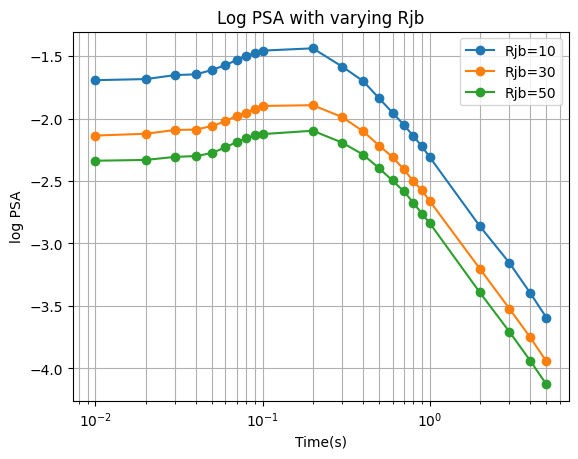

In [ ]:
l=[]

rjb = [10,30,50]
focal = 0

r1 = [4,rjb[0], np.log10(rjb[0]),focal, 760]
r2 = [4,rjb[1], np.log10(rjb[1]),focal, 760]
r3 = [4,rjb[2], np.log10(rjb[2]),focal, 760]

l.append(r1)
l.append(r2)
l.append(r3)

l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rp = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rp)

plt.plot(t, prs[0][2:], "-o", label='Rjb=10')
plt.plot(t, prs[1][2:], "-o", label='Rjb=30')
plt.plot(t, prs[2][2:], "-o", label='Rjb=50')

plt.xlabel('Time(s)')
plt.ylabel('log PSA')
plt.xscale('log')
plt.grid(True, which = 'both')

plt.title('Log PSA with varying Rjb')

plt.legend()

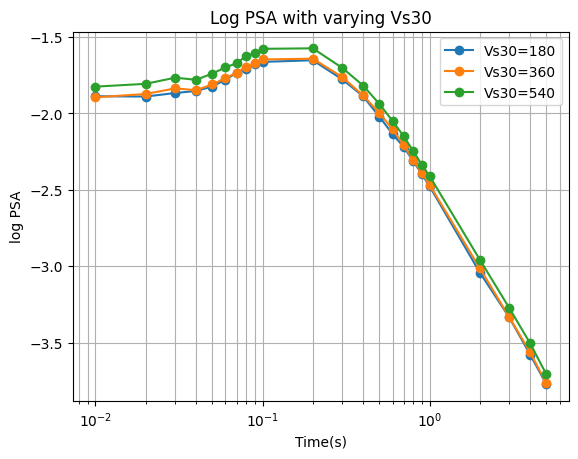

In [ ]:
l=[]

rjb = 50
focal = 1

r1 = [5,rjb, np.log10(rjb),focal, 180]
r2 = [5,rjb, np.log10(rjb),focal, 360]
r3 = [5,rjb, np.log10(rjb),focal, 540]

l.append(r1)
l.append(r2)
l.append(r3)

l = torch.tensor(l, dtype = torch.float32)


with torch.no_grad():
  rp = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rp)

plt.plot(t, prs[0][2:], "-o", label='Vs30=180')
plt.plot(t, prs[1][2:], "-o", label='Vs30=360')
plt.plot(t, prs[2][2:], "-o", label='Vs30=540')

plt.xlabel('Time(s)')
plt.ylabel('log PSA')
plt.xscale('log')
plt.grid(True, which = 'both')

plt.title('Log PSA with varying Vs30')

plt.legend()

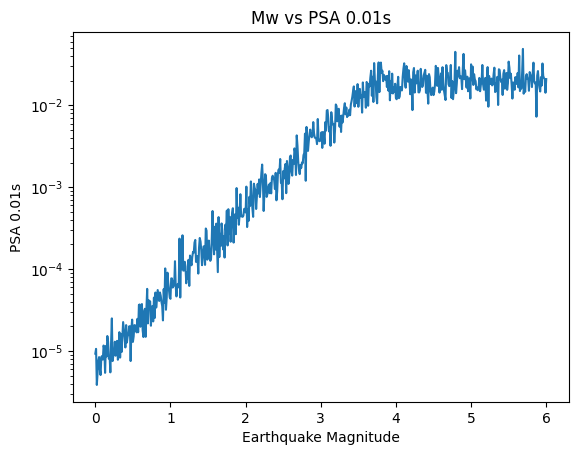

In [ ]:
l = []

rjb = 10
focal = 1

mw = np.arange(0,6.01,0.01)
for m in  mw:
  r = [m,rjb,np.log10(rjb),focal,760]
  l.append(r)


l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rs)

plt.plot(l[:, 0], 10**prs[:, 2])
plt.xlabel('Earthquake Magnitude')
plt.yscale('log')
plt.ylabel('PSA 0.01s')
# plt.grid(True, which = 'both')
plt.title('Mw vs PSA 0.01s')
plt.show()

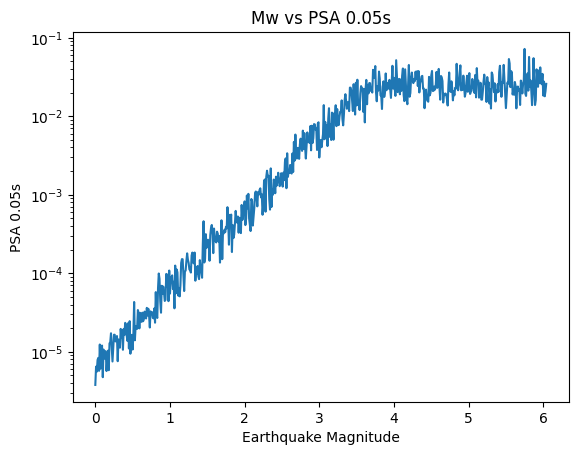

In [ ]:
l = []

rjb = 10
focal = 1

mw = np.arange(0,6.05,0.01)
for m in  mw:
  r = [m,rjb,np.log10(rjb),focal,760]
  l.append(r)

l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rs)


plt.plot(l[:, 0], 10**prs[:, 6])
plt.xlabel('Earthquake Magnitude')
plt.ylabel('PSA 0.05s')
plt.yscale('log')
plt.title('Mw vs PSA 0.05s')
plt.show()

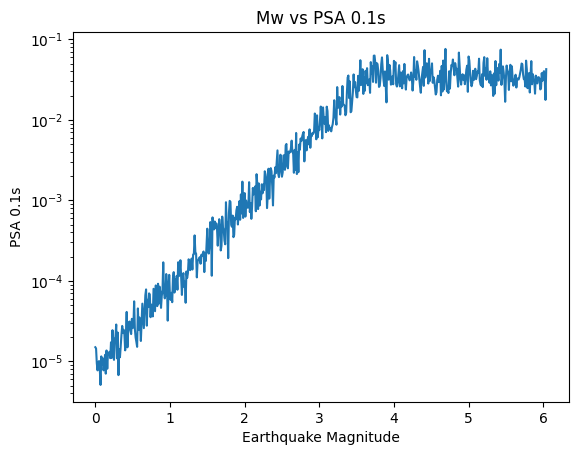

In [ ]:
l = []

rjb = 10
focal = 1

mw = np.arange(0,6.05,0.01)
for m in  mw:
  r = [m,rjb,np.log10(rjb),focal,760]
  l.append(r)


l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rs)


plt.plot(l[:, 0], 10**prs[:, 11])
plt.xlabel('Earthquake Magnitude')
plt.ylabel('PSA 0.1s')
plt.yscale('log')
plt.title('Mw vs PSA 0.1s')
plt.show()

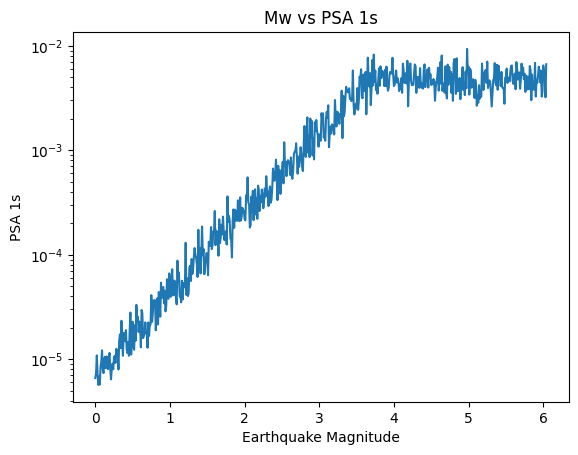

In [ ]:
l = []

rjb = 10
focal = 1

mw = np.arange(0,6.05,0.01)
for m in  mw:
  r = [m,rjb,np.log10(rjb),focal,760]
  l.append(r)

l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rs)

plt.plot(l[:, 0], 10**prs[:, 20])
plt.xlabel('Earthquake Magnitude')
plt.ylabel('PSA 1s')
plt.yscale('log')
plt.title('Mw vs PSA 1s')
plt.show()

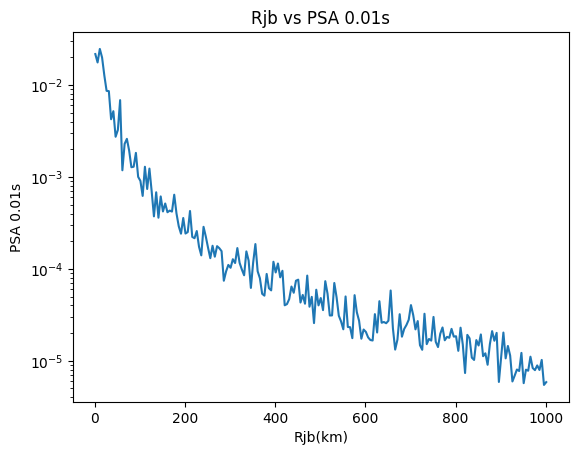

In [ ]:
l = []

rjb = np.arange(1,1005,5)


for d in rjb:
  r = [4,d,np.log10(d),1,760]
  l.append(r)

l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rs)

plt.plot(l[:, 1], 10**prs[:, 2])
plt.xlabel('Rjb(km)')
plt.ylabel('PSA 0.01s')
plt.yscale('log')
plt.title('Rjb vs PSA 0.01s')
plt.show()

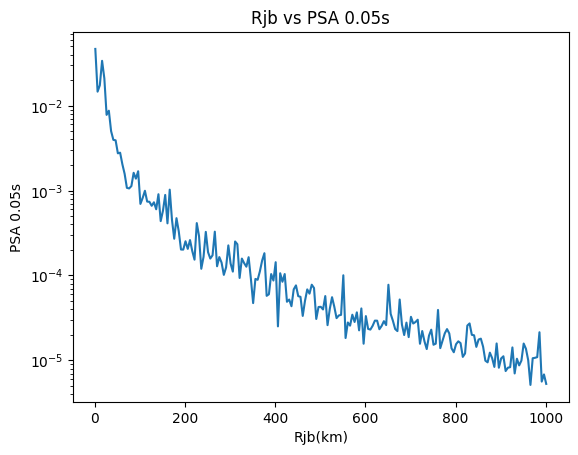

In [ ]:
l = []

rjb = np.arange(1,1005,5)

for d in rjb:
  r = [4,d,np.log10(d),1,760]
  l.append(r)

l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rs)

plt.plot(l[:, 1], 10**prs[:, 6])
plt.xlabel('Rjb(km)')
plt.ylabel('PSA 0.05s')
plt.yscale('log')
plt.title('Rjb vs PSA 0.05s')
plt.show()

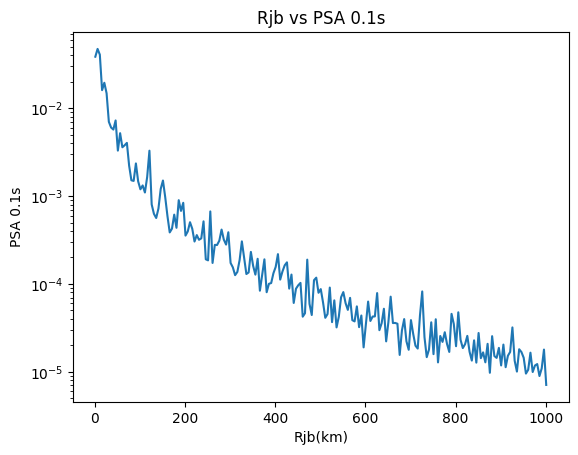

In [ ]:
l = []

rjb = np.arange(1,1005,5)

for d in rjb:
  r = [4,d,np.log10(d),1,760]
  l.append(r)

l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rs)

plt.plot(l[:, 1], 10**prs[:, 11])
plt.xlabel('Rjb(km)')
plt.ylabel('PSA 0.1s')
plt.yscale('log')
plt.title('Rjb vs PSA 0.1s')
plt.show()

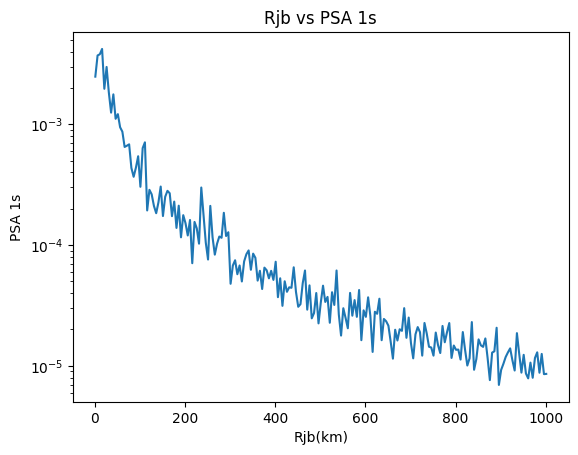

In [ ]:
l = []

rjb = np.arange(1,1005,5)

for d in rjb:
  r = [4,d,np.log10(d),1,760]
  l.append(r)

l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rs)

plt.plot(l[:, 1], 10**prs[:, 20])
plt.xlabel('Rjb(km)')
plt.ylabel('PSA 1s')
plt.yscale('log')
plt.title('Rjb vs PSA 1s')
plt.show()